In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('session_data.csv')

In [3]:
data.describe()

,session_id,product_name
count,345152,345152
unique,165335,396
top,27d86d946e6ea6d022f12211d61f8ac7,onion
freq,9,31196


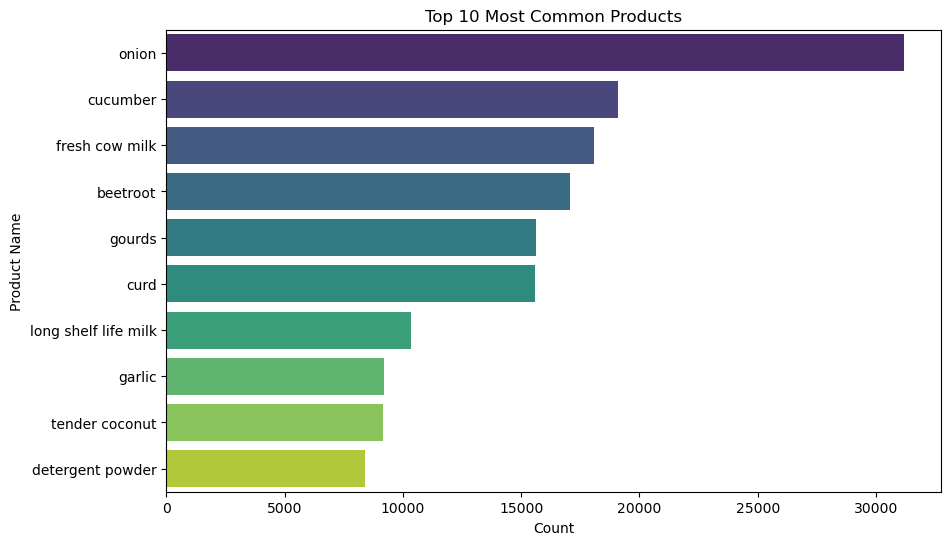

In [4]:
product_name_distribution = data['product_name'].value_counts()
top_10_products = product_name_distribution.head(10)
colors = sns.color_palette("viridis", len(top_10_products))
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_products.values, y=top_10_products.index, palette=colors)
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.title('Top 10 Most Common Products')
plt.show()

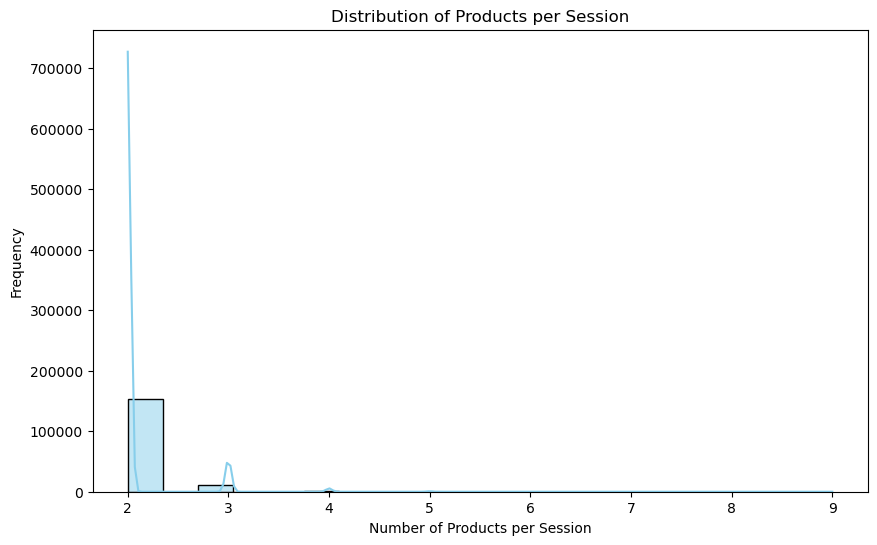

In [5]:
products_per_session = data.groupby('session_id')['product_name'].count()
plt.figure(figsize=(10, 6))
sns.histplot(products_per_session, bins=20, kde=True, color='skyblue')
plt.xlabel('Number of Products per Session')
plt.ylabel('Frequency')
plt.title('Distribution of Products per Session')
plt.show()

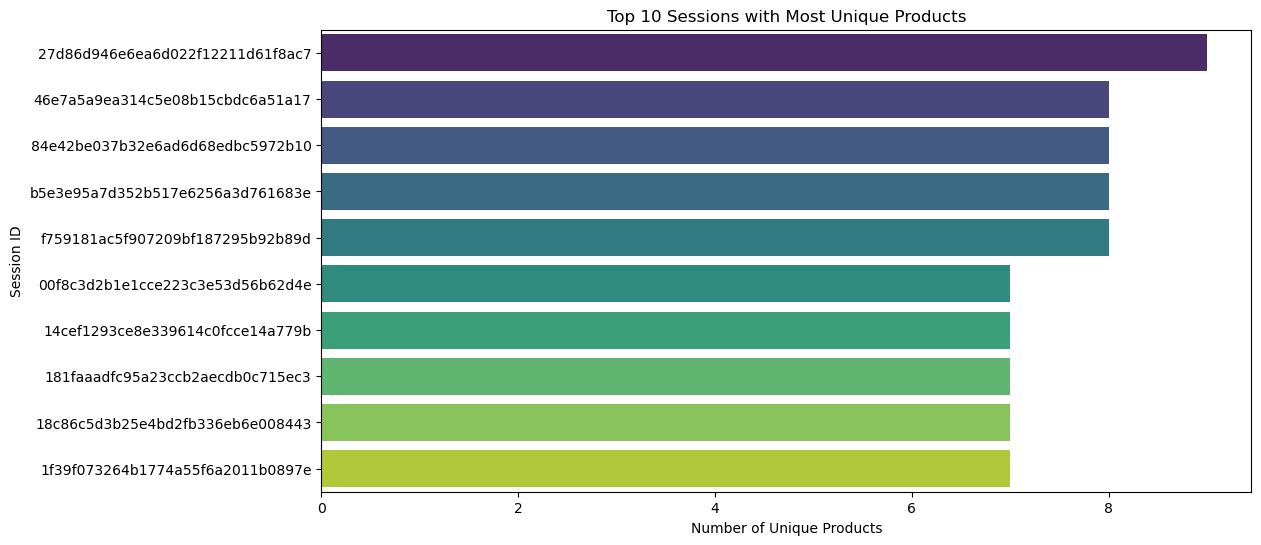

In [6]:
unique_products_per_session = data.groupby('session_id')['product_name'].nunique()
top_sessions = unique_products_per_session.nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_sessions.values, y=top_sessions.index, palette="viridis")
plt.xlabel('Number of Unique Products')
plt.ylabel('Session ID')
plt.title('Top 10 Sessions with Most Unique Products')
plt.show()

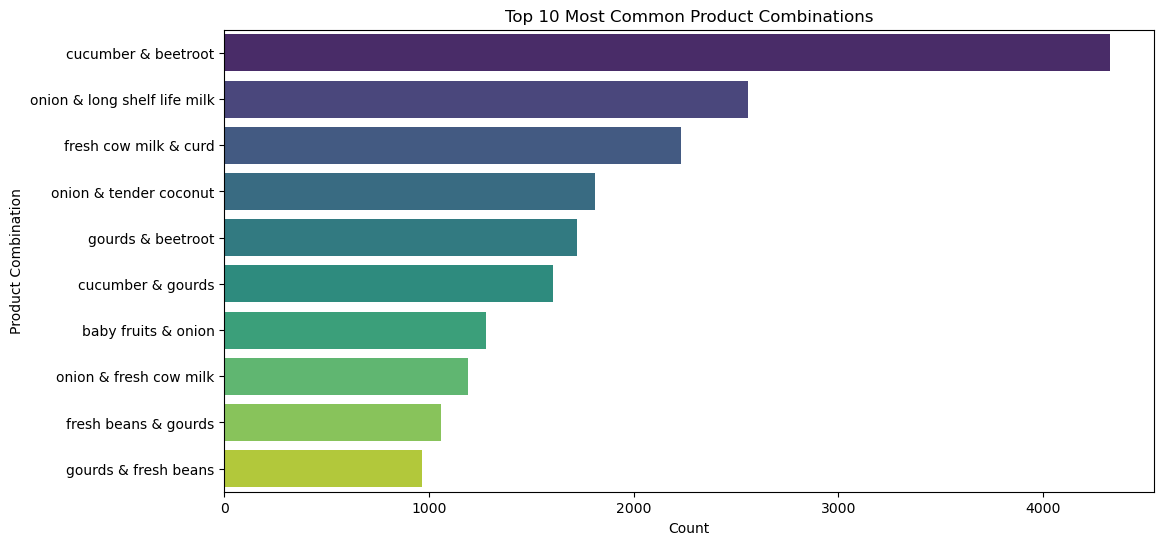

In [9]:
from itertools import combinations
from collections import Counter
sessions = data.groupby('session_id')['product_name'].apply(list).tolist()
comb_counts = Counter()
for session in sessions:
    comb_counts.update(combinations(session, 2))
most_common_combinations = comb_counts.most_common(20)
most_common_combinations_df = pd.DataFrame(most_common_combinations, columns=['Combination', 'Count'])
most_common_combinations_df['Combination'] = most_common_combinations_df['Combination'].apply(lambda x: ' & '.join(x))
most_common_combinations_df = most_common_combinations_df.iloc[::2]
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Combination', data=most_common_combinations_df, palette="viridis")
plt.xlabel('Count')
plt.ylabel('Product Combination')
plt.title('Top 10 Most Common Product Combinations')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
sessions = data['session_id'].unique()
train_sessions, test_sessions = train_test_split(sessions, test_size=0.2, random_state=42)
train_data = data[data['session_id'].isin(train_sessions)]
test_data = data[data['session_id'].isin(test_sessions)]
data_rec = train_data.pivot_table(index='product_name',columns='session_id',aggfunc=lambda x: 1, fill_value=0)
row_sums = data_rec.sum(axis=1)
data_rec['sum'] = row_sums
data_rec = data_rec[data_rec['sum']>=0]
data_rec.drop(['sum'],axis=1,inplace=True)
data_rec

session_id,0000bc46bf70d6ebb01c8b58f5e619ab,0001978dc214c82cb21a5a3d450ba431,0002276867f6d276dc39a3261e30b2ca,0002a1009370d0d675e449a32f94f711,0002e76e639563ab3a7c7cfca6033c07,0004023b626e58a7e4cea8d90f4ed63e,00045195505b4724ee770cd23074458d,00047a22fc404e52e15cbcf3879567ff,000540a72db3a9d7a824fd841f8b839f,0006281d01a1b4bae8ea1b52af1d7d96,...,fffcc8e57ed62ef898b4c321995fb920,fffde145d14d31cb7210ba3bf856fc8d,fffdffe99c2975e6f261fc590e033072,fffe547fe948f699a37a639553ac48d9,fffe624d79b71263fec13d4ddd1e5692,fffed0f986ae3933f0830538adc37864,fffed3a44b22a0ad079f5ecf75c38e75,ffffdfdb1e329a1ffde4f7eef3ff01d8,ffffeeaa83df2ff6c902dadae7e6ed75,fffffcd6989cd65bc9dd67e13d6dadff
product_name,,,,,,,,,,,,,,,,,,,,,
a2 ghee,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adult diapers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adult nutrition,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agarbatti & incense sticks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
almond,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
white eggs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
whole wheat breads,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
woks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_score = cosine_similarity(data_rec)
similarity_score.shape

(395, 395)

In [10]:
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
dense_matrix = data_rec.values
jaccard_distance = pdist(dense_matrix, metric='jaccard')
jaccard_similarity = 1 - squareform(jaccard_distance)

In [11]:
dense_matrix = data_rec.values
pearson_distance = pdist(dense_matrix, metric='correlation')
pearson_similarity = 1 - squareform(pearson_distance)

In [12]:
def recommend(item_name, similarity_score, jaccard_similarity, pearson_similarity, data_rec,k):
    items = set()  # Use a set to avoid duplicate recommendations
    found = True
    similarity_score = np.array(similarity_score)
    jaccard_similarity = np.array(jaccard_similarity)
    pearson_similarity = np.array(pearson_similarity)
    
    if item_name not in data_rec.index:
        print(f'Item "{item_name}" not found in the dataset.')
        found = False
        return [], found
    
    index = np.where(data_rec.index == item_name)[0]
    if len(index) == 0:
        print(f'No similar items found for item "{item_name}".')
        return [], False
    
    index = index[0]
    similar_item_1 = sorted(enumerate(similarity_score[index]), key=lambda x: x[1], reverse=True)[1:k]
    similar_item_2 = sorted(enumerate(jaccard_similarity[index]), key=lambda x: x[1], reverse=True)[1:k]
    similar_item_3 = sorted(enumerate(pearson_similarity[index]), key=lambda x: x[1], reverse=True)[1:k]
    
    for i in similar_item_1:
        items.add(data_rec.index[i[0]])
    for i in similar_item_2:
        items.add(data_rec.index[i[0]])
    for i in similar_item_3:
        items.add(data_rec.index[i[0]])
    
    items = list(items)
    items.sort(key=lambda x: (similarity_score[np.where(data_rec.index == x)[0][0]].mean(), 
                              jaccard_similarity[np.where(data_rec.index == x)[0][0]].mean(), 
                              pearson_similarity[np.where(data_rec.index == x)[0][0]].mean()), reverse=True)
    
    return items, found


In [13]:
recommend('yoghurt',similarity_score,jaccard_similarity,pearson_similarity,data_rec,11)

(['onion',
  'curd',
  'chocolates',
  'cakes',
  'tender coconut',
  'grapes',
  'whole wheat breads',
  'protein bar',
  'bangles',
  'premium chocolates',
  'cakes & pastries',
  'fruit juices',
  'mango',
  'bajra flour',
  'a2 ghee'],
 True)

In [14]:
def evaluate_recommendation_system(test_data, similarity_score, jaccard_similarity, pearson_similarity, data_rec, k):
    precision_scores = []
    recall_scores = []

    for session_id, group in test_data.groupby('session_id'):
        actual_products = group['product_name'].tolist()
        if len(actual_products) < 2:
            continue
        
        # Extract ground truth and input products
        ground_truth = actual_products[-1]
        input_products = actual_products[:-1]

        # Initialize recommendations set
        recommendations = set()
        
        for product in input_products:
            recs, found = recommend(product, similarity_score, jaccard_similarity, pearson_similarity, data_rec,k)
            if found:
                recommendations.update(recs)
        
        # Calculate precision and recall
        if ground_truth in recommendations:
            precision_scores.append(1)
            recall_scores.append(1)
        else:
            precision_scores.append(0)
            recall_scores.append(0)

    # Compute precision and recall at k
    precision_at_k = sum(precision_scores) / len(precision_scores) if precision_scores else 0.0
    recall_at_k = sum(recall_scores) / len(recall_scores) if recall_scores else 0.0

    return precision_at_k, recall_at_k


In [15]:
precision_at_10, recall_at_10 = evaluate_recommendation_system(test_data, similarity_score,jaccard_similarity,pearson_similarity, data_rec, k=10)
print(f'Precision at 5: {precision_at_10:.4f}')
print(f'Recall at 5: {recall_at_10:.4f}')

Item "body perfume" not found in the dataset.
Item "body perfume" not found in the dataset.
Precision at 5: 0.5909
Recall at 5: 0.5909


In [34]:
top_20_products = product_name_distribution.head(20)
top_20_products = top_20_products.to_dict()

In [37]:
top_20_products = pd.DataFrame(top_20_products.keys())

In [44]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup

In [45]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('webdriver.chrome.driver=C:\\Automation\\chromedriver')

In [50]:
item_link = []
item_not_found = []
for item_name in top_20_products[0]:
    driver = webdriver.Chrome(options=chrome_options)
    driver.get('https://www.google.com/')
    text_box = driver.find_element(By.NAME, 'q')
    text_box.send_keys(item_name)
    text_box.submit()
    button = driver.find_element(By.CLASS_NAME, 'nPDzT.T3FoJb')
    button.click()
    try:
        images = driver.find_elements(By.CLASS_NAME, 'mNsIhb') 
        soup = BeautifulSoup(images[0].get_attribute('outerHTML'), 'html.parser')
        item_link.append(soup.find('img')['src'])
    except:
        print(item_name)
        item_link.append(None)
        item_not_found.append(item_name)
    driver.close()

detergent powder
chocolates


In [51]:
top_20_products[1] =item_link

In [62]:
top_20_products.iloc[9,1] = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUSExIWFRUVFRgVFRUXGBgYFhUVFRUWFxUVFRUYHSggGBolGxcVITEhJSorLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGyslHyUtLS0tLSstLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAOEA4QMBEQACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAAAwQFBgcCAQj/xABTEAABAwIDAwYEEAoKAQUAAAABAAIDBBEFEiEGMUEHEyJRYZFxgZLBFCUyQkNSU3N0k6Gxs9HS8BUjJGJyg6KjstMWMzQ1VGSCwuHihBdEY8Py/8QAGwEBAAMBAQEBAAAAAAAAAAAAAAMEBQIBBgf/xAA1EQACAgECAwQKAgICAwEAAAAAAQIDEQQSBSExEzJBURQVIjNSYXGBkfDR4UKxI6EGwfEk/9oADAMBAAIRAxEAPwDcUAIAQAgEK2o5uN8hF8jS61wL2F7XOg8a9istI5k8LJUJuUaJpsaeTxPiPzPWguHSf+SM+XEYxeHFnLOUmE/+3l74z8zl76sn5o8XE4fCx9T7bxv3QS9zR8pKjloJrxRJHXwl0Q4ftW0C/oeXxc39pceiS80S+lLyI6flCiabGlqPJb9a7Wgm/FHD1sF4HDeUiD/Dzjwhv2l76vs80een1nY5RIPcZf2PtL31dZ5o59Y1+R2zb+E+wyd8f20fD5rxQXEK34MewbXxu3RP8qHzyKKWklHq0TR1UX0Q5G0QPsL/ACof5ij7B+Z323yPfw//APBJ5UP8xedj8z3tvkeHaEe4yeVD/MXq078zx3ryE3bTsHsMnfF/MXXosvNHPpMfI5/pZF7nJ3xfzF76JP5D0qAoNpo/c3+VB/NXD08v3J0r4sSk2shbvY/yoP5q9Wlmzx6mCGk23lO32OTvh/mKVaGx+RG9bWvMbHlIp/cZu+L+Yu/VtvmiJ8Sr8mWPAMYZVxc6xrmjMW2dlvpbXokjiql1MqpbZFui5Ww3IklETAgBACAEAIAQAgBAN8Q/qpP0HfwnsPzHwFex7yOZdGZJiTRJrceUT81MFvVNxXMw7oxkQr6cjfbvHnaFaUslLbjr+/8AYrTva072d8XnXko5OlJLn/H8kxHVNcPVM74fsqs4Y/WWo3Jrr/r+SIxNjCfWHxxeYhTQiyGViz/8/khn2G637PmKkSPM5O4pT97fUV0RyiO4pyN33/YRxOenQkKbE3t4/wAPniUUqosljfJEzTYrIeP8H8hVZ0RLkL5MWlxR1tSP3XnhC5VETt3NEbPi35ze+D7KnjSVpan95fyMpcQvxH7rzBSKpETub/V/Ik2qN947mfZXWw53v9x/JL0Nc8bj838gqtZWmW67MClXVvdxP3/8YJCCR1OWSEq5Hdv3/VBWoopWMZkn7/8A4UhEaxyaD8iHvj/nHYFg8Q999kb/AA/3P3Za1RLwIAQAgBACAEAIAQCdQzM1w62kd4XqeGeNZWDE8QrIo3lrpnA9RFR9S365uS5R/wBGFOlxfUb/AIVh93PdP9Sk9r4f9EW1fEcnFoPdz3T/AFJmXw/6PVWviEjjkY3TO/ffUvcfIbX5iEuNxn2R37zzrtcvA87NsYy4nEfXHud9a6yedlI4GJwj1x8l31puPewkxRuMU/t/2ZF5uPfRpCgx2n90PkyrzJ16LIdQ7UU49kPkTfWo3HJLCmaFnbWQH2Q+TN9a8UDp1yGM20MR3SP7pPOVKiB0TGrsbj9s7ud9pdZRz6PM9bjcftneS77SdTz0eY4j2jjHE+S77a4cUdKuxHbtpo+s+Q/7a8UUdOFgi7HIjxPkO+0u0RSpmxSkxKJzgAXeS761zOxRR1DSzZt2w8WWjj7S8/tkeZYGqlutbNrTVuFaTJ9VywCAEAIAQAgBACAEAIDIa7DmzmaM/wBZBI9va5gcct/FZbFNmzD8GZ9te9NFaqMOI4LVhYmjInS0xsaHsXe6JxskIvovzUzE9xMQko/zU9k7W8aS046l7tiSx3DWSIdS92IlTYkYWr3s0SJs9ZSgrnYjrcx5DhgK4aidJslYsAOW+U267G3eoXOOTrDwdDBB1JuQwzw4CDwXu9Hm1nDsAtwXSsicOLPGYCT61HZE82SLVszycidnPTu5uK9mgWDn9tzo1vbbX5VR1GvVb2wWWT1ady5yfIlsKwHDWTGIsbVOAtZkJLRfLZz33PWbkkAZTu40p6q19HgtKmC6pBjGBUlNmkjaWFwNm30abX6NwfOOpdwusn3iJwri/ZNC2cphFSwMHCJu/fcgE38ZKz7JbptlmKwsEkuDoEAIAQAgBACAEAIAQGN7R1/oXGpWn1Mojk7LOYGn5Wla1C30L5FaxYkdYiWslLTud0m+AqzVlxyU7IrcctgaV3uZz2aOzQg7hque1xzZ1Gnc8JDatwh7PVMIv1ghew1EZckzuelnBZcSGqqHsVmMyu0iGqqRTxkMojHxkKVM9yhWJy5aOskth9Q24uVDOLPW8I03ZyrikiYwylrgCPUgt19SN+4Wbpbr61jamqak2lyL2i1tcYbJLJYqiijY0OdI2x3fi73ytJI07OKpKUs4NCvbZ3YISMEPug3G/wCKHADXdrrc+DwXXu6R32a+BDl9LDZoztDeIyaOcy+d2XrNx3cVzukcKCWVsOG0rGkEOFha5azK7u6iF7ukdKCXSJF1lFBmyPlLg512wszG+uhyt4nfw86lzKUc46eJQlmM2v8Ao6gqHk83DSmNjT0jIObGh1DWD1R3bzwUX3Pezz3mZvtXj76itjgjOUOmjiFgLjM9rNDa/HetKupRqbfkQYzI31otosUtnqAEAIAQAgBACAEAIAQGCcuPQxOJ43mmj+SSVbPDudbXzK95xXVnO08EvEXYfFuV2qOJNFWzmsi9DVEpOJHuLPgjS51gbFZWsk01E3eFRj2crH1JSupyzebjiDqqqbNaDjNYwRYwQyajdcj7/ItGrU+zzPk9dpXXc4x6EbW7MOtp1K3DUoz5VTRW67AJG72nxK1C6LIW5x6oh56AjgplI6jcMnxELomViZ1FPI3c9w8DnD5ivHGL8DtYJmhxuqaLc/IR1Odm7s17eLeq06K3zcUTwunHutomINpKgezHjwbx330UD0tfkTLUWPrJjn+k849kPyW7bC1hfj1rn0WvyHbz8zg7azt9dfS1iBa1rcLFPQa34HvpNi8SPotrJI5uesHusbXJFidLgjdpceAqSzSRlDYuRGrnu3MmqXbiqdHNI5waGt6AGYnMe17nfJZV3oa4tIkV8mUbZGYy4tSuebl1SxxPWc2a/eu9UttUkvI9r5yPqFfPFsEAIAQAgBACAEAIAQAgMC5ej6YxD/LM+kmWzw3uP6le8hsFkLqdzOo3Wm1iSZRnLkSuEMJIAC8nhFGVuXhFyggdA1s3tT0h+aePiNljav2uaPo+CWbZOqf+XT6kni1WHMDgdCFUR9DTU4ywLYI1zmEj2/8AtapKmsczB4un2/LyQ5lpH28SnjNGTKMhjPC4b23CmTXgQttdSLrMEjlBsLFTRulAilTGfQqeK7POj4HuV6u9SKkozrZCvorHUKbJ1C7wPDDZc5yWtzXNpiRJC9wdKwTknPWm0kUho+QldJHuTznF7g9H9U8spre2KixmZ34DLYZ9sSpD/mI/lcB51S1nu5Firqj6pXzpbBACAEAIAQAgBACAEAID5/5ddcTZ8Fj+kmW1w73X3K14z2Mp82ZvW1aFzwkzKnLLaL1gOEiIZnDU7lUutcuSOaq9vNlggpC/Qi4OluBB3gqpOSSwWq1LcpIr9bRvgc+mdcgN5yEn10fVfrbqD4AeKz5Swfd6S9X1xs8ejLTsG0Ppr8ecP8LFwpGTxWC9I+yLEacL3czNcEN5qAFSK1ojlSmMZMKAN1MryB0JMSmw1j22dbxrpXOPNHnYqXIo81EyWRxhYCwaBx3O/Ot1dXf4Op6mySwfQ8P4Pp9Ni25Zl5eRBVcRa8xvAIO42Fx4CuK5OPNM+jnpqdRXiSyiMqMMcBmtoePg0K36blOCfiflnEaHpNTOrwT5fQi5oCFOQQtyMpWWXSLCmN76r0lTJXH9I429l1BXzbJGMNjj6YUnwmH6Rqqav3cvoWKup9Wr5suAgBACAEAIAQAgBACAEBgHLcL4o34NF9JMtrh3uvuVNUx/yb0d334WVrVyxAyaFutL7GwOfl6lQziOSz3pYLHQ0tgqNk8s0Kq8IZ7U4XzsQewXkiOdn5wt04/9Q+UBV5c0aWju7KfyfJkfyfPHNzMBuBLmb2sfGwsPjsuK3lFjifOxS81/otikM0EAlKy66TOZLJSscrxKTGx1ohpJJwd1sb1jr6/Bvk355Gtw/Qdm1bNZl4L/ANsgK7aSKJuSPcO8+FerLNuvRzm90yGoQ+qlDspyDiB59wU0Y+BJqtXRo6m5SWS6QU0WQRkDQW79T8pKsx3Q6H51qtQtTbKcvEgcb2WBBcxXadV4SM23S45wKLX0BYSCFoRknzRBGxp4ZGcx0h4V63yLlc8jvaje0dTQoqujLTfMjdljavpPhMP0rFV1Xcl9CzV1PrBfNFwEAIAQAgBACAEAIAQAgMC5ZhfFR8Hi/ilW1w73X3KOsfItHJ/Hljzda61b54KWli8NpFwwyIFxPaqdrwizTHLLFE2wVB8zQijsrw6KXQytpK6Rh0jkOW/AE/jIyeoXfKwfohV09tjXmaU07tOn4oud1YM0SqqpkbS57g1o4n76nsXjaXNnUISm8RWSo1+LT1hMVMw5NznE5Qf03etb+aLuPG25Rqe7oalVFWm9u58/I9h2FDwDUzOfb2OP8XGOz2x8IIUyeBZxaa91FL5vmyUpNlaOL1FNHccSM7vKfcrvcULdbqLO9NitRQC1gNFPC3BmW1uXNkPVUJG5WoWZKM6mhCOYt0O5duOeaOY2Y5MjcewRkzS5o1UtF7g8M4voU1uRnNbRFj7EbitRS3LJTrm4vDGe0rbuH6IXlXQ0VLmRezf9upfhUH0zFV1Pcl9GXauqPrFfMl0EAIAQAgBACAEAIAQAgMD5X/72/URfO9bXD/dfdmfrehI7JRxZXOkf+MGjQddOoDgFRvcnJ5PsdNXXHTQVKW3HNj/D9o5Kd5yvDm39Q+5b/pO9viNuxVZSkvEmv4XRYs4w/NFww7b2keLSO5s+EOb4i3XvAUXaLxMi3htsOmGS52jpcuYTtPguT3AXR2RXiV/RbvhZU678q5+YjKH5BHewIZEHWc47hcuf4iqVknbP2EadSWmUVJ+efuRjNon0/QNcxttMhIcR2WdqPFotCrh+rkuRVu1eh3d0VwWRlfUBjqtr9CSM55xwG9rA4aDry3suLOH3webVyO1xLTxhihc/3maTS07I2hjGhrRoANwXSWFyM2UnJ5k+YsvTkLIDhzF6mctDOrgaASbAAEknQADeSeCkhNoinXkpeKY9RMJBnaCL3FxfySQb+JaVcLWs7WUp0JvqO4nFpLTu3I1uWUQRk4vDIHarBg4Z2hWdNfj2WQamn/KJQto4ukPAr9fQ5hPmQez4/LqX4VB9MxVtR3ZfRmrR4H1evmS+CAEAIAQAgBACAEAIAQGBcr59Nj7xF871t8O919yhrehZtjqaKWMF7GuIFgSBfwX3rzVQW7LItHq7q4bYSaXlkteD4ZAHEiCO99+Rt++11RthFLkW69XfN+1Nv7lnZE21sot4AqbLKbIbGNlaeYEtbzMvrZYug6/DMG2Dx2G/i3riUIyWGWadVZW+uV5My3a7aCRsUUAJa8szSOB1uJJI9D4Yyb/neC2pwbRRw7JeZX4vqMWbI/X8kFg2BNliMjnljcxY3K0ON2hpJIzCw6TfDrutre1/E46SSjjOSvoeGy1cZST6EbNHJTzEB2WSJ5yuHBzHWD29ml1oRlG6vPg0Z0ouuePFH0ng1bz8EM27nYmSW6s7A63yr5OyGybj5PBrReUmPFwdAgBAVTlLq3R0Ly02JOW43jouII7Q4NPiVvQwUrkmRXNqDaMx2G2MbXslkfK5jY3BgDQC4uIzX10AsQtnWat0NRiijVVvTkzS8Rp7G6z6pZWCO6GHkRYOcaWlev2Xk8i90cMzfbSjySHTgtbTz3QM+a2W4Khgjfy6l+FQfTMUWo7kvozW0z5o+q18yaQIAQAgBACAEAIAQAgBAfP/ACxn02PvEXzvW3w73X3KWs6Fh5PasCzTxU2rg2smXpZpSwy+0shDuoLMmvZNCDxInI3qm0Xosj9o8VFPESD03dGMbyXHjYbwL+PQbyFHOW1FrT0uyePBdTJ+UHZqeOKCqczoiPmngamJrXOdEZDxJzuzO3XA61s8HuUYdlLr1RS4mlOzfDoV3Z/GOYJY8ZonG5G4tJABc0jrAF9D6kcQCrnEOHw1UefVdCLQa+elly6M0TAdncPr3PfI3O+wIcyV7czN2rA8gEHfbTW28ELKjfqtNHY+i6ci1fDT2vfDx6iW3uMy4aYYKZxEbYWMa0uebNZmA1DgSbAam+5WNHTHUbpz6la6zs8JFq/CEn4MZPnOcxRuLr6klzb69oJCp9mvSHDwyTKXsZKhsJtVVVXornZP6umL25c2jtel0nO1V3W6WurZtXVkFFzmm2V8coteHOAcOLR6o27em5wv4utW/V1LSZE9TLODuor6yWiqHVTpCC+Lm898urJ82S+nBu7sXMYUxviq8eOTpym63uIjAZ8Rjjd6DdI1jiS7IGnpAZbkEE8PkVjULTuX/LjJDX2mPZ6G3V8Vx4lh1S5kt0eRCw9F6ty5opw5SK1yg0mmZWtFPlgg1kcSUjNcHb+X0vwqD6Zil1Hcl9GXdK+h9Sr5k1QQAgBACAEAIAQAgBACA+e+Wg+mx94i+d62+He6+5U1XQ72QqsrgtC2OYmA242ZNWwWcSC/FY18dpq6eW8XxXGmU9s3SeR0Yx6p3aepv5x08eipyaSNbS6S2+WIrl5+Ax2YhdVTOq5tcpyxt9aDa/RB4AHQ8SSd4Fq0Vl7maOscaIqiH3ZKYvtTRQF0U8mUjRzSxxuCAdwBzCx8ytV6e2fOCMqU4x6lKxPYSkrofRWGuDcxdZlnNjcWOLXBocLx6gi1raaW3rQq11tEuzv/ALK86IWLdAzSkqpqaUPY50csbz4WvabFrhx3EEeELYnCFsMPmmUoylCRaeU3EhUPppQLc5SRSW6i/OSPEqXD6+zU4+TaLGqedrL3JJ6Qxu/y0J+Vizcf/sa+ZY6U/Yo/JmbMrz1Ub/kBWjxHm6/qVtL0kccllEyavu9ocGNc8A6jMDobdhIPhAXvEpuFGF4jTJOxsvnLCfyEe/N/gkWbwz3/ANmWdT7sa8jH9lk9887l3xT3qOdL3C6VrdFSrfM6tXIrVQ2zx4VoLnEzJcpEZtpFmhv2KTSP2hq45iZNhI/L6X4TB9MxW9R3JfRnei8D6gXzRsAgBACAEAIAQAgBACAEB888tf8Aep94i+d62+He6+5V1Iy2cks4LVmvZMG9e0XnD8WkaBHD/WPv0jqGNG91uJ6vH1a4+u5YR9D/AOP6FahSts7kf+2JVsJY7K5xc95u97jdx6ySez5FmSjyPt63HZmKwkaRgdPzcTG7rNBI6i7V3ykrnGEfIX2Oy2UvmZTyw0rmVjXkdGSMOaeBLbNc3xWB/wBYW7wqSdTXkzN1a5pi+wW30dHTmnljcQ1znMc3d0tS1wAJHSubgHeudboJW2b4s6ovUY7WVHFKg1dU97GG8r9GgakuOunWXEm3aBqr1UexqxLwIJPtJ8iV25p2s9CBrszRSsjDhuJhLmut3tPjCr8Ps37388lrX1SqcYy8iUdttG7CmUIjfzojbETpkyxkHMDe9yG7raaqL0KS1Pat8s5OHenXt8RryfaQYkf8lL/CV1xDv1/U40/dl9BxyO/253vLvnavOK+6X1PdJ3mXvlUpTJRtaB7M0+IMkWbw+W27PyZbvi5QwhpyR05jgma7fzg06tL6rviUlKaa8jnTx2xwXGs3KnA6s6Fbqm9LzLQg+RmTXtEdtcfxB8HmUmm741PcMiwj+8KX4TD9MxXNR3JfRnui8D6eXzRsAgBACAEAIAQAgBACAEB898tY9Nf/AB4vnkW3w73X3KmpInAvVDwLWfQxLebLFRxzFwdDq8aZbgEi9xYkgday9dS3iSPoP/G+K06eM9Pf0bymTWGYVVyTtkqG82xu8EtLn/mgNJsOsngs6MGz6DX8Y09dLhRzb/6NHoJrriyJ8zVLJ3jmEU9VFkqWNcwagk5Sw7szXjVp36hR12zqlmD5llxUlhlPHJbQuOZs8pb1BzCB4w1XvWl6XNIg9FgWLZ3ZCjpDmiZd/t3EOcPBbQHhcC6q36q23vvkSwqjDoVvENn2SST0ssTnR5zNA8Bwy85q5rXgWGtxl3WA03Lui6dftRNe+FWqohKb5rk/sQFLs1Ax5Y6nkc13RLi5xdlvqYyGhodp1HxK1PWXSxhnEuE6SNbe/mX3Cth6SBkzI+cyzxOifdwPQeLGxtobcVTt1ltjTl4GXGmMU0jzAtkaKhm5yJ7g/KW2fIDo4g7rDqC9u1d10dsun0PIUwg8omsZmjZHeQXbw8Nj/wAqCpScvZJWQuw8sbhOY22bzg1vfN0d6m1Sktu44g+uCbrX6KOtcyO18itTuu/xrQisRM2TzIittn2it2KXSLMsnOseImV4GL4hS/CYfpWqzqe5L6Emi6o+nF82bAIAQAgBACAEAIAQAgBAYDy1N9NB8Gi/jlW3w73X3/gp6pkTgcXSC1ZP2TFnzZaMFu2TxqC3nEgr5WGgluZgPYsnOHg2GsxyL0M4Gi4sjk6qngzzlKxyV9W2nZJzbRlBdewbmOW5PrbEOJItcWvuV3Q0RVbsayS3WPKiiCxBgoKwPhqBOzQ84CCJWWbzkb7Ehw1cLedWI/8APS98cP8AcEbeyaw8krjcs2GYk17XOLGnMxpJyuY5tiPARx6723KGiENRp9viSWSlXPPgcbNwvq5pq6azmU/4zpDo8+49CwOlw7pnxcCmoUaoxpj1f+hU3Nub8CPooZK5s0rnvFrkN1LB+Le8c52WYQXHW9ibqSycdM4RS6ntcHfGcm+hM7D49NS01XG9zgxkYfGL+o6Qa/m/a3DgRwuL9ag1lMLLIuPV9RTOUYvcQ2GQmrinllqw2RhbzcBcAJXE3dljzbrdQOu9WbH2MowjHKfVkSe9OTY6oMeldh00bnF3NyxuYSb2EjJbtHZdoNu0ridEVqYtLqmexsfZvJceRuUmCoJ91H8AVLiixZH6E2neYtlsxKZVqonF0yJpo7uurM5YRUrjl5Kzt7Nfoq3oo8slXWy9pIz7Z1vpjS/CIvpGrvVe7l9C3o+qPphfOGwCAEAIAQAgBACAEAIAQGD8s7PTRvwaL6SZbfDvdff+ChrGNdnYdQtGb9kx85kTrei4+FRdUQy5SyWzBKrO3KVQvhteUaWns3RwxwTkcuV7SPX7LMt2qY12KSNlOVhkju7dZjo43Egn9J2q0dO2tP7PXn+SWXOayO9oaHDqecwRMlnNgA5s7bXIBtpEevh2qCqeoshvbS+xLKNcZJDjlAxI1tc2niGYRfiW5QCXPF89uvpXb4r8V7oq1TU7JePMXy3zUUJ7LYwRQ11EbZubfPF1kxgGRvbowOHgcmpqXbV2+GcMVSeyUPEc8mOMtpo65xe1rmwtfGHH1Tm85YAXBdqWCw61zxGl2Sgl54GmntUjrFdqqrEKCqztYGR82eg0g/10QNyXHTK52luC5hpa9PfDD5vJ07HZCRE7M4XRSUtRPUSESREZIxI1mYO0AN2k7+ICn1Vt0bYwguT+RHVCDi5M4lfCaOZ0MT2DnYWkvkD7ktm3AMbbd1lexU1fFTafJh7XW9qLryNH8mn9+H8AVHinvY/Ql0/cZaquzjYhV4ckRWc2eBgjbdM7mElCJQtrTmcStbTLETH1MszKjsxHfEqX3+P5HArnVe7l9C/o5e0j6PXzhtggBACAEAIAQAgBACAEBiPLNH6Yxnrp2fJJKtrhz/439TN1vUQ2bZqFfsfIyF3iTlGpXkehDZ1FcMrSx41XllW6J5TdskXFrhK243rMacHg2U1ZHKK9jmzMFU4OkzseBlzsIBLQSQHBwINrnXQ9u5T13Tr7n4OVJdJIVwHYSlhdzgdI949Q52WzHcHhobYkHUX0uNyiv1ds1teEizUormiS2a2EpqScVDZJZHtBA5wtIBcLZtGg3tfvUF+ssthsaSXyJ664xe46dyfU/ok1TZZGuL82QZMnayxbq0jo26tF56dZ2fZtLB72Ud24j6nkmpC/MyaVjfaXa4DsDiL28JKljxW5LDSZy9NBssuE7K0tPTvp2szMlBbJm1LwQRY2tbed3Xfeqlmpssmpt810JowjGO1FVm5J6TNcVEwb7XoGw6s2VXlxS7GMIrvTQ8ySrdkKQ0opGl7GCQSFzS3O54BbdxII3Hq4KKGpt7XtPHoJ7FHae7N4XFRMfFE57g92Yl5F72tplAXV0p3NSkQqcYraibjF9SoHy5IkSzzYwxBwecoOgU1a28yC1qXJFS2ggGui0aXlGTekpFU2Yi9M6a3uzT3XPmXOqf8AxS+hd0fOcT6CXzxvAgBACAEAIAQAgBACAEBjPLQz8thPXAB3SP8ArWxw3uP6mbr/AAENlGXI8Cv3PETIh3x/VjpOXtfQht6sjnOsVYSyihKWGTuC4qWEAnRU9RRu5l/Sava8Mt9E1knSNrAXPUAOtZVjlDkbtSjZzITZ3EZaiN0z3zxRue+aF1ohE6mY85Y73HSc0X6VrDjxPt8YwltSTeMP6lmEH4sWO2sADi6N7C2aOG5cwxB0sQlYXTMJa1uUjXXUgarz0Wfg/DP6j07k24jjEnOQPY6OCOR7CRmEsziIqe1vVnQ9gcF4tI5Yw85f/S8T3djwLAK05WlwyuLQS298pI3XtqoVVzeDmVuDz0XcL3szntRnPXqaNJXneMHzucVOoqJXc3LoLQQW6TlxKWeSJIQxzY1xHF8ujVJVp2+bINRq1BYRGU9Zd3hVmVWEUq9RmQntEdPF97JQj3US9oqWyI9NKb3wnuY8rzV+5kW9D7yJvKwDfBACAEAIAQAgBACAEAIDIOWxlqmmd1xPHkvH2lrcN7sjN166Ma7Hb/EtDUd0yKu+PcQ0cV7V0ILurIl51VtGfM6ifZGskWcFkw2sjfTy075XRmVpjztF3NDhYkX42uszU0S3qcVnBvcO1sIR2zZ3X4PC+WmpH1E5zRh1O1scQhYymLXvaWk6l1mXzX3DUblSjOcVKe1defnzPoItSSwyKFNSPponskqpG1zqiMtyROebyuMsjs7w1lsuXnLmwy9hUu61TaaS24f9f0e+ySUmzkRrmQwudIwSiqqHPILGOYxrYIYyB6qwa7iQ1o9trwtRJVOUuXgv/bPXHwRZcMq46l8+UOPMzOhzG2V7mgZ8ljuB014gqCblWo58UQulPmdTMN/MNw+tdxawV5ReRGSlDWue91g0Fzj1NaLk6dgXTtx0OOx8WMaLG4HC7L8bXtrbfuJ+X60ipTeCPtq4rIxxDGHO0ar1WnUebM6/WuXKBXMWxN8b4mc2SZSQLg2JHAGxFxe9lW1uonU0qzZ4FoNNqoylqs/JEnQuJIu3Kb7u5T6eydlWZmfxPTafT6t10PK/18j3amQ2HgU2mRS1PeRW9hdcVp/03/RSKPW+6l++JoaD3kTel8+b4IAQAgBACAEAIAQAgBAZNy4N/GUZ/NmHyw/WtbhvSX2M7X9ERWyLrXPYtO5cjDg8TYrXT3cVLXHCKts8saAXUpXayKtjK8yjhxYtHCbhcyksBQeS1TYK+eaB18rGU00cjgbOtKWXawjUOIYRfgHE77LDnZGKkvHK/wCj7DTOWxL5ERS4BVw08DPQ7ZCKd3RsxwY7OXshs82bdzi55AJJytBGXMunbXOcpbsc/wBf8Eu+cYrK8P1HtHs9UwGPm4s5p4cjWue0sL4WkU80ZzXDi97y5trAaakApKyE85fV/wC+qOt78h1s5s86ilEkrriCn5tjr/1sspzzvsD12GouTmJvdLLFcsRXV/hLoc2XKtNyJRmLOcdy7enSRlrWbnyGNWaeoGStmIiL3MDGl8XSuA0ucwgmwO46DeVmPe3g3kqtilFfcrlHHHG3mon85kc7M8A5HjMcpa6wDja4OgtoLLQ4esSe7qY/HJOUYbMYX5JzDGsBHOaAuAvYnU8NNfGrOrt2Ryilw3TdtPGPmTWNYbRyNbNKw/kxcWZbtOosRu1uQLeFY8Yztmo+LPpXdHS1uXRIrNXWxOmzQtLWaDKeDgLGw4Dd9ytnSZ7N1y6xPmuIxSujdHpNZEdqH3aD2Kxp1jJWveWiH5ORfFIeznD+6eq2vf8AxM1NAvbRuywDdBACAEAIAQAgBACAEAIDLOW8f2Q+/f8A0rU4Z1l9jO4h0RC7MMtG53YtWx80jBXizyOIvcVO2ooppOTJalwq+9V53lmGmz1Hv4NAUXbZJXp8HJpgOC935I3UOo62QbjZROqLJ43WLkmeSTvdvee9FCK6I5lZY+rYg6Rw9ce9SKMfIicprxZ4XudvJKYUeiPMyn1YqxhGoBJ4NFrnjpcgbgTqeCissS6k9FDm/ZZwKB0jnEkuZJYkPs2wytJIFhoBxsdOtZc17TlHwPo4OPZxqsXN+XgN4mxZ3MYMoa7I1pvoBoACfAdDr4d60KLko4fUxtZpJubn1Q9r4RkaAx7jmFsoBF75bONxa4cR478FBqczWGXuEzVM8/Ih8SrqgxCJxa5rS3IC52a2YtvI/UOI04eNc6KeyTaXP5lzjenjbCM3yTfh9M9CJZFI06yAgnNbKLjU6Ag7raagnQarUrolv7Td1PmbdZX2HYbOj5PPQlceZeBruxd1vE2iOazFMiOTU+mcX6z6J6rcQ90zV4e/bRuqwDcBACAEAIAQAgBACAEAIDI+WiqDqimhG9jHvP6xzQ36M961+GxxFyMziEuiOMIpSIQwDUq85rdlmNKLawiZocLyC5UVl+7od16fassVfVNbpdcquTOnbGPIRkxALpUs4d6G7qwFSKsidqOfRAXuw57RHpqgmwdohGSqC7UDiUwjqkcDxTHTa8NF+rq32IINu+/iVW6ltci5pNQoT+og/F5JHaOaYgwRDfdwbvNzc6+pvxtxVeGmb6dDQu1sI4z3uXQ7jmGlho9rQ83Bs52VryNNSHC4363XHZyjEm7eM7c5+f1FqbE2vtEXA57gOzAlkjLv4a2IbcA9R1Gigk3h4ZZrhBzTS/8AhFV8hike53RyepzC3qdzt5uCRftv2a9aemUk5dF4kfENbucaMZecjSAGRubIbDeQLtHiBJA8IWnTrIpJMyNTwqe5uDXPwHEz3c0Y3braFWPZk90Sit0PYkiA2Pl5rE6cn3XL5YLP9yg1azVI09E8TifQK+dPoAQAgBACAEAIAQAgBACAxnE6V1dik8nrGP5sHsjAb84cfGtqlqqlLxMi5dpY/Itb5o4G2A1AXkISsZWtsjWV7EcXc42BWjVp0jKu1UpEd6IKsbEVd7D0QU2ob2ec+U2obz3nym0bw9EFNqG85MxTaebgExTaNx1z5Tae7z30QV5tPN5yal49SW7wbObmHRcHcCCPUjiR2Ktdpd/deC9pdd2WN8c46eYwxFrp2Nh6bGs6Rc7KbkXsBbfckkkW3WtqQKi0blyxj5mj6xjU3Zu3N9EuWEOqGENbTRnpOY92Y2s1xZFI+AgEmxEoj8YC9lRKqG2TzHKPIaqu+12VpqW1jihqZInaXLdSCLWHEA3N+vhuy9qmdeJ7cciv2m6rfu5rwJWmxCKRxhkbbM3O09Wpa4d9j/qVfZKuxxiXJSjdRG2fXOGVfaLDH0szJm6gOa9p7WkOHyhTKfaJxZzCHZtPwN4pKgSMbI3UPaHDwOAI+dfPNYeDfi8rIsvD0EAIAQAgBACAEAIBGsnEcb3ncxrnHwNBPmXsVlpHknhZMkosap4mWEgudXHiSd5W0qZN80Y07Eo8iKxPaAO9Sbq/XFRRlWQnNkNJib+ClczlaVeIia+XhfuXO9ki00PI5NdL1nuXm9nvo8PI5NfJ7Ypvke+jw8jz8ISe2Tex6NDyPfwhJ7YpvkPR4eQejZPbFN0h2EPIPRknWU3MdhDyPfRsnWU3sejw8g9GSdZTdIdhDyOfRcnWU3SHYQ8joVsnWU3s8enh5HfouU7s2hBBANwWkFrgbbwQCPAubMTi4yO6q1XNTj4HX4Zkb6sOH6LSWnwAat8B3dagVtkFhrPzRZelpte6Lx8me0WLky86/ogM5tjTa9s2Zz3W3Em2nAAJUpObsn4jUVxjVGmvnjm2WN+PQyRGN7gQfHYqOdbUso7p7uJGlcndXzlDHY35sujv2Nccv7JasnVx22v8mrpnmtFlVYsAgBACAEAIAQAgBAMMe/s0/vMn8Dl3X319Tizus+fJW3+7vrX0+DAbO6ehJ4H9rzFDjcTFFhJ6nd0v1KOU8COX+/0SElEGjc7um8xUSbbJXiKIStpddx/b/wBxViKIHIjZKX7/AHcu8HsZiXoT7/dy8wddoLR0JPA9x8zkPN47jww9R7pPMvGxkcsws9R7pvsrly/f1jP7+oVGGnqd3TfYXO795fye5/ef8HEuGnqPdN52hdKX7+s8b/f1DJ9ERwPc7zldnO4fUFGTwd+9/wBoKjm8HSf7+osNPgxy7nfvftD5lVdvMtwh7JC4jhxBOjv331FWISyV3yf7/BX6nDzfce5/nAUiZ1nBzFR24fP9pdYI3M2fkrbah/Wv/wBvaVhcQ999kbGheafyXBUS4CAEAIAQAgBACAEA2xKnMsMkYNi+NzATuBc0i5711F4kmcyWU0ZxHyXSjfUR+Qtb1nH4WZT4dP4kPYeTl7fZ2fF3XL4lF/4v8nPqyfxL8Dn+gb+E0fxQ+tcesI/C/wAnvq2fxL8f2Ju2AkPs0XxX/K6XEI/C/wAnvq2fmvw/5EX8nUh9nj+L/wCV0uJRX+LPPVs/iX4EHcmkv+IZ5H/C69aR+FnnqyXxI5HJlL/iGeR/wnrSPwserJ/EhePk2kHs8fxd/OuXxOPwv8nvq2fxL8C7eT1w9mj+J/7Ln1ivhf5/o7XDpea/H9nf/p+73aP4n/sufWC8n+f6PfV8vNfj+z3+gDvdo/if+yesF8L/AD/Q9Xy81+P7PDyfu92j+J/7L1cRXwv8/wBHnq+Xmvx/YhJycyH2eP4q3nXa4lH4X+Th8Nl5r8C9FsA5huZmH9WPnK4nxBPon+TqHDpJ5bX4Jd2y5y2D2j9XH9hVVqFnLRbeneMJkNUcn8jtefi+J+oq1HiEV/i/yVfV885yvx/Y0PJnJ7vF8V/2XXrKPwv8h8Pn5r8f2eHk0l/xDPIsuvWcfhZG+GTf+SLjspgzqSDmnODjnc64FhrbS3iWfqbldZuSNHS0umvY2TKrlgEAIAQAgBACAEAIAQAgBACAEAIAQAgBACAEAIAQAgBACAEAIAQAgBACAEAIAQH/2Q=='
top_20_products.iloc[17,1] = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUTExIWFRUXFx0bFhYXGBobHxoYHx0WFxodGiAYHiggGxonHR0bITImJisrOi4uGh8zODMsNygtLisBCgoKDg0OGxAQGy8mICUvLS8yLTUvLy0tMjcvNS0yMDAvLS8vMDUuLS8vLS01LS0tLS0tLS0tLS0vLS0tLS0tLf/AABEIAL0BCwMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAABgQFBwMCAQj/xABCEAACAQIEBAQEBAQFAQcFAAABAgMAEQQSITEFBkFREyJhcQcygaEUI0KRUrHB0RVicuHwMxYkQ1OCkvEXNGPC0v/EABoBAAIDAQEAAAAAAAAAAAAAAAADAQIEBQb/xAAyEQABBAAEAgkEAgMBAQAAAAABAAIDEQQSITFBUQUTImFxgaGx8DKRwdEU8RVC4VIj/9oADAMBAAIRAxEAPwDcaKKKEIooooQiiiihCKKKKEIooooQiiiihCKKKKEIooooQiiiihCKKKKEIooooQisu55+IGKwmLeCBY2CZb5weqBjse7A/T3rUa/O/P2LP+JYo208S1/9KqtvtW3AxtfIQ4aUs+JcWtGVXWF+KeOcXKxDzEWC9k63PfX39NK7p8TcfcflxWuL3Xpax2fvr/tSAnF440MRDG51K2Jvpbt2FRHxTlgqq2Y7KVIPvqdB611DFhQKoWsYMxJNkLc+Ruc5sZiPBkEekWa6gg3BUE6k75vtT9WZfBXgPhxy4pyGkkIRbbKgAYgHrckXP+Udq02uNisnWkMFBboA4M7RtFFFFZ05FFFFCEUUUUIRRRRQhFFFFCEUUUUIRRRRQhFFFFCEUUVmXMvxFxGFxc0CwxOkbAAksCbhG1tp1Ybdu2tHvDBZT8PhpJ3ZYxqtNorKIfi3L1wYPfLIfXuvt96s8L8UAylmwjKAOkitfQGw0/1fsO5AqJ2HitB6MxQ/09R+1oleVkB2INJGE+JmGcX8KVdeuXv6N2saxteCTkkiUBmNz5mFyST09yfrVXYho21TYOiZ33mGVfpzNRevzK3CsTGL+I1tvK7bWAtvtYAfQV1TjuJi+Sea+/8A1X75up760v8AlDktP+DfVl4+y/St6+1+cIOduJJoMVL6A2bpbqD0/vTDgOf+IXF5gQehjXvfoBp09qt/JbySv8LMfpcPX9LbqKyZefceP/Ib3Rh0I/Sw62P0qTH8SMX1wsJ9pGXt3B6X/cdtbDEMKW7obFt4A+YWoV+f/idyviVxkjxrJIGYyAhbgByTsBckNcfQU9P8Tii5nwtx1Cyajfa62PTr3qu4nzyuIxuFGHCvFKiK17hkZmbMNDa6gC4tr3pgxMgY50FEgXR00G6x4nBSQ117aB8Csh4bgH8aPzAEOt++hBOm5Nr6Vdrw8uWCA+MZhYageHc31ubH9RHvWocbiwuIhxniYfM+HjY53TLrkLqY3GrDTWxpC5UJGOhgy3QlRcaEE5b/AH/rXQ6MnGIjM5aWkDbffvXNnttRjWz7LdOXMH4WHjS1ja59zqb+utWdfAK+1jJs2tSKKKKhCKKKKEIooooQiiiihCKKKKEIoopT4xzxFC7RrDLI6mxsABfW+pPoP3qrnBu6bDBJMcsYspsr4TWaY3nfFsPKIYB3N2ba2gOm+o+m9VOJ5kdvnldz66DpsBYAaUl2JaNl0o+hp3fUQPX591qeM4vBF88qj637jp7Uv4zn6BdI0eQ+2Ubeuu+h0771m+J4nm329TUaLjABIViWOyoCSfoopRxJOy3x9CxNFvJPoFo0nN07g2QRA/KSC1tt729enWkzinDBLK8zzqXc3Y2y69PoBpVdLisW/wAuHlP+oZf561yXCTtIInIEp+WMkxg+iu1jK3ohA7NfSqEvetMceHw2rSB4aldnwUCavMD9Cfuaj4jiMGUrGXNhuBp9bEC1MEHKqCESeGskrEZVfIANRo4kaRg52C33IvbauGHwkMwjlgijSRZFWSNhaNg3lRnUDo9rgWBzDbW1TEb1TW41pBc3UDTh815pU4bjkUEXuL62BP8AKpv+KRDTMCf2/nWu4PlWOw8WSSVvR2jQeixxFVA97+9dpuV8OwtlYf8AqZvs5ZT9RTf4ruaw/wCcYNK+fO5ZAnFlHVbe4qNipMPJuwU+4NPPM/JZijaWCOP8sFzlRRnAsWRxa6nKCQyEDSxXUGuPDOCQyKZs8jRFRJGl2vlYA2JAyeVrqbAnT1qhw5BpaB0swi60Wcz4UrqrBh6H+m9SuH4aSXSMAkai7Bb7aAtpf3Ipmm4LBP48ZjWKaIOylCNQoL5WsAGBUHzWBuOoNgzfD+PCQYYFnTPKPOGvYDWy+YW66+tQyKzROiviMaGMLmtN6aePHwWezJPGxSRMjgXKmRcwXuQCSo968mV+i5j2V1Y/sDm+1aFzVFBCi4zDyqzYd1JRWDfkMQkqb38M3Bsdtbb1JlwyCFoY5GXVkJ8TMSLsigeKGte3yrlsAbHQXYYAsrelHUCRv5LJcZxcqGGU6DzBt/a1MHJPLHjwRYlJWilDmRdAy3DnLcaEiwF9RvXTHNDiMLh/FjBY4yCIuBYmNizOtxrbKoPpmNS+HcW8I4ad8PMIgJGZkQMAZApU2U/JYtvYjTSs03WtjBhdRPhrodKO9nRZOk8R1jjE8fT78/smHm3HYtcMyfhl8N7JJMsmYKpIFspUNdr262vSv8O4PE4qh6ICT/MfyNMGK4k03BxKzZvFnOU2A8gmdkGg6IgqD8GcNnxk8v8ACtvrt/U16Do5vU4BwIAN18+68y/tYgeC2Wiiisq1Ior4TS7xLjTZ7R2yqdSf1H+1ZMZjYsKzNIfLirsjLzQTHRUDhfElmXsw3H7XI9Kn0+KVkrA9hsFVIINFFFFFMUIooooQiiiihCKyf4k4KZcVeGF38RC9xooygB7nvYA29RWsVG4hgkmQxyC6nsSCD0KkagjoRS5GZxS1YPFHDyZx4L84YTEPJKsZJTM2Um1yPpcfzFeONK8EzxZyctvNbLe4DbAnSx71acaR4MXLYkOkhNwSDrrvvqD96n8+qGMUyplWWK4JHmJ/zEi7aFbX1tbvXOyijzC9aJnF7OTh67+yhcucsNOI5JQzGUkQQ3K5wNWkdhqkS6ajU3AG9ajwrlGCBfPZu4H5cY72RTY+7lj61TcbknhI/CqxdUgiUIpayFZZH2GgJ8MX02FL3GMLxAKJMSfDBPlDuCx7kaswA9SOg3IFaAWx/wCtrlObLiqJkDQeHHyHzitClxmAiFrQ27IgI+uUWH1pa49xnhssTQeFlV2BzoEBRthKoQkXHXUEjTXakVFZ7sVdwN2Fzb3Njb61ccH4phI/nwkch7sXP73Yj9lqv8ku00CeOiWRa25x7iB+UycJxrsDFMWMih0fL1dQ13UgZszpIkgIBJvKagYrDrHNiIgQHxKARsNhLmVyCNCpZsu4GXN1G33iXG8JKVkjAglXLsFZPJ8l1cxm6i4BHQkEEaV2wI/FurtiRIYyGRIo8pMi3ZVLzMxzNrrqGy2vdaae0NNVjY10ZOcFtjUe23fzSx/ieLRVfxdGvazLcWJFmCm6m42NdIOZMWdBK5PbxHH/AO4rpheHYVsVL+IxHhRh7iNAzHzHMUzEeWx0Ol/amHGcucMxRC4SbwpQpIHnKsANcwfr1uCOp1pGR52Pquk7EQMAD2eeXQfO5cuH4rixaNvDd4iy5iG8QMlxmHzsLEXr1ywPD/IP/hF0Au2yT4hTYAbgMj30IKp9KOHEYvBEur5owdZI2zKe2Y2/bOvtUuLmBZZfEEgglcgOcl0YkoLsuYFflS7I36blRTI3gaEm+9ZMTh3P7TA3Lzb+Rqu2VY5MdLmzSJh7IovrdFjd7sBcC99tQT2pQwKJmAdmTuQAT6HUj7/vTdxbCNHDPNJIGklw4UBImUAFwGza5QwAKntXX/E8NiMKwnwj5oEQIygq+TRM17HQG1wbjUaVVzL7tynQzlgsAkGhY4UANL31XzBcreLFMYcYJy2HkURlCrXZfLu50zBdRobb1b8IxBkiZhmN3JUeUXuVmXcXspY3DbEt9FhOA4qOJcThS0sR8wABDruL5Rqf9Sa+gr5wvHw4iW0yWY6u6u6E5SC+bIQGIQM12BN01Jvpdjw2hVeyRPCZbeH5gO4WPEaKg5rxwGDwUUa5LTzM3dmVIwGvvcB8v0FP/KLYmOFvHjS0ajJ4JJLABrix/VYKBbcmkHnxR+Ow+ERQghZltmLm8kieY5t7ixtTinE8ZhQsjeDNCPmCjw5Dfa2ZihPoLX9Kw9JjNFHF2bPPurZcuY5pXuAOp9+a78+Rw/hYZo4zGZXDEWKEgxsfzE2zjQXIuNRepvwVwmWKaS3zMLH6E/2pU5w5o/GxqFjaNUJAD2zFmsLm1wALWGp3NaN8L4AuCDDZ3Zh/p0Ar0rGmLAtaeJtcdtOmceWib6KDSNzJzvEHOHhku2zsgLEdwuUHX16fy508zYmlzltjidIaaFY8x8as3hIQbfPY7HTT+9UrSVWxWcWVbgGxFiCDvrfUHrrVFJzCyI0uQ+GrsgLsAxKkAi3c62/062OleMxDZsdMXAa7V7BbmtEYpOmGkK+YGxBpn4ZxdXsjkB7bdxoL+5PSkLgfH4cQmaM3b+E6EH1qwgkG9zmvcnbX0peFxWIwEhBHi0oexsgWh0UvcI41skn0b6dfX1pgvXs8JjIsSzPGfLiFgewtNFfaKKK1KiKKKKEIoNFFCFinxQwPh45mGYiRVYkjQHawPsL1X8SxEMvD4gXAniuoXdiu2pzeVbEdL3XTQU6/GLCXihl/hcqde47e4rL4oixsN/cD+dc2fsPPevWYEtlwrHONZT/xbFw/jEcYeZj5XggddvMT4iBRfS+g9r60kYqSfimKyJqNyR8qoOvTToBpmJvpfSfgMI0+BjhawdbwXJ8upWSAkjpmVU/9Zp45d4NHg4RGmpOrud2bv6DoB0FPAMwAvsrmtmiwgc9ur9hyAHFKGC5zw2EjEGGhYkb5vnZ/1FlG7X7HTbpUXj/MEk2HDPg445M5uZogM66kFPEUnMOo+oO4qV8ROMS4fwxhgsQkZvFkUAEvoQCRrr5jf0/fMeK8adwUZWkP8ZYhiffUFdtD62IvWiKF7zRPZ8FGeLKJg3W71JJPNfONYxWl8hSJcoDBSTc9dCdPYWFT+UeMYaKQLJiTHc6s0ZKsCQSCUN47GzBrGxF9LUrCAyaCNgfbb3NcsRBY+GouQfMQb/tatz4x1WSuz+Vm66TOXN4+futW5oEPiriiiYhW/LmCOQruReKZTGf1KDcbZlYetVsXGMJH50wZjkAJRjJIVBII1Vn8ykGxHUE0p4DFLDFIpBKOuVxr8w1U6dVb+vem7DfE+UIFyxuALXyvta2t5L39xXIIBJI9l0g57GhhFmtsxGngrzlDiUeEfw2jTJMAxkRyVVTYAEMTpe9+2l71bczcmYNwzKwwz/5flN+6f/zas75f4rAX8PWMWJUk3sR5ranY2A1O2nqOfBJYMV+JDYckTTKI8RJd/wCIOSGa11BUiw0GhIqzXsNh+3subK+aKXM1xv38U4czYOQ4EC4kZJVu0dyrLIoz7f8A5VLG+2YVD4vhuKYWJZZpgyRMCGWV2sT5Bobaa2+teeG8iSxSE4eVUF7rIpZfL0LFRYe1zvXfEY/FRlxZMVGjZWKl1Y6AnzLla2u5Dem1NEcMgtkm/kpjxz2UHNBF/PBPXLnE55og00WQ2UqwZSHUi4Iyk2+ttx9OPGOC4aV1lZMsgN866EjYh+jAi416Gs3HN8shVMG05kOn4ds0jWAJJRlNmUAbEA1V43nXG5beJckZjfLZUvlubLfMSCAAaCSDkcNVQx1c0bgAeAv7KFzMzYniCknKxjjVn/zRoxc9NfL9hTOqr5UlnOeIA2lkyvrcggMQMuq2Yk+9Jqxzyv8AiBFdHc2zNlzZ1kYgW2GUN1/qBa8L43+Lf84Eywg+EoVVtYBLsW2YWHYeUaCl4iJ0gaBt5bpLZGtcT8pMvMfEIin/AHgDyC4QZc7MLkG6nygkDY666WBIuvhDjcTnxCurDCIB4blhkVlCZ1tuCblug3rK+MO0uJSONGziNc65i2aZrtIxJOxFvbbpTfFhTgIHKNKxxDrliZrguQNwLA+a9j6qO5pT3twkbYybcTo2/nmURtOIf2duaa/iNzdJ+HcYclUPlLjQvoSQvZbDfr7b1+L4HFgcHny5mGUMRoXkbS5Otlv9rCuXH+HDCxKk0D42eVTnZi/hRnbKipa519O+l7V44dzcwiXDYjDPLIQEy2AMnbMrDQ6XJ20J0GychILZzZP2HcunHC4Ma6MW0GzqBfr7rny9xl5WeR08qqkbuuwsWsWvvbMoJ6XH0U+dMZJiMXkAJCnJGnr1P1Ot+1u1aPh8E0AvKUBf/pYSECwXXMCxGqm/mYgDsCTqnY/gWJgkZ4cP4pcAI6Zm8K+hW29gNA397VTCNhw2MLjWcimgnw17v1skYlwkGYCh+FC8uFeONQxZQL6Nmcm5Hh20uWNiD0sOhpz4BHiJYEmkAVySLD9VtNVO3UVScncusCSy5pBZTIdVj/yr/E3e3tpvWn8L4FmF3UooNlAOrAAC57e3102pfSmGbLUMPbk3c7gO7zvbfRZmvy6nQKpwUJdwijX7ev7U54bDZFC3Jt1vX3DYNI/lW3r1/c1Iq/RvRQwoLn6uP2SpZc+yKKKK7CSivEsoUFmIAAuSTYAdyelVnMfMeGwMRlxEgQfpG7MbgWVRq24vbbc1+e+d/iBieJNk/wClADdYVN77ayHZyCLjQWv9akC1YNtbEPivwrxfCM7DW3iGNsh+oGg9SAKdMPOkih0YMrC6spBBHQgjQivx1k/3P/N6ePh/8SpeHDwHj8XDXJyjR0J3Kk6EE6kHqdxQRSks5LT/AIqcxQIgwjDM8gJ/0kKWT6lgD7e4rJmJFmXcaj/n/OtWGLjxPEsS+MwwWRI3UvmIUrp47swfZQVCg/5ANarDL5nBOoc6/W4NYJr0cV28DG2SJ0HHfzV/w7jeVDqbMLMBuDuCPUGzA+lMfEfiKxVVjjBYoCWP8ezDKCLa2O+zCszeXI1/0kaj/n2NcBiGOoJHqNP5U7CYR9ktOhWW23UrbpW3HcbjJpBIwzgdPKBbsB2vf19a74VTIoXJr1Jt5R++vsKp4sZKdA7AdTeonEeLlfLGxBtZjfX1rrsfPC06trlR/akvw4/9en6VlzBxPw18GOy920LH9uv8qosFiVGhBC/ub9zUELc33qSiWrPIX4jWQ/oJTcQWOtgr1UjCTsmYbhhqD/OvvDhGpJe/oLXH/wA1xvRQ6BpB70Mnc0tO9bA7Lo8maQrGLgnTobbnU7daY8Hx50DoBlCoqR38gVBmdrlQbXsBoNfMb1K4ZyBKVimxBMcUgzBoyGcC2YALb5mGot0310qBHy3i8zy4fMYy5WNZjkeZQflt8hcWvkzBtLgVmlwgcBxVXzh1nj6K64hzphPDkUxSQ4hVyr4Lq8bjTLma4ututsw/cH1wnE8MypnxSl9DIbmxbKHbQLmyliV02tvfSlzjPKTpJlkQYeNGCPIwkCG7BQwJ8pGt/wBJsdRoTVfzry6mEmZImDxi2Vw2YEWBvcaG+9XgjMYLmrG83or3ivDMPnEuFxhUIc7TKCPDsBotrEuSSAB2A1uSKeSM4oqkYKhnWONbXLNogLEaFrfRQLCqPCzuY/CLHIGuF9ban/neth+F3DMMsCShzNPexXKcsGbMDbTci922W5672dbteKqDW678ciaDDWBCKBlAKxkG4KgLYnQXvcn/AMMggjSsy4bIZcd+UpYEnNudDcEknvvr96dviJipsZiFwcB8sYvNIdlLAaE3+bLbS/WueBiiwcS+EpaIsFkmVvOzdQl92O1x62tvWTGYoRERR6uryHef0tOGw7pdeCk4dsPg/FawadtW0vY/oRj0AtsO2utqZODcuJjMLHJPiHOIkQTR5WA8IGzRlU2NvLcnrpUbhHCocJGJuIxEl5RFBGwWTIjaqWC6FiS1ybkW09ePF8EIeL4SPDN4Z8thuEQeKzoB0QoreXa5uLaVlhw2R/Wy9pxO/EfpbbYGmOHSgTfA1w8PdWg5wxodoGwAklj+dkYhbb5tVOVSNRc0cTxhxcWCxCRCLEZ2dVbW0YEiPqADkcFbG361NqsOYZI8VBFNBPdfFHlWxEhvkKsrAgkHzWI/Tr0InYTAJEDNKxZjuzm7NbYdgPQAAXNZuk8d/HaYxq4jTagOaWOroPDa3011+/D+lF4dgGJaWZlDMbk36D5VW+uUD03uetd1xPiN4cNggKhzmyswLKpy+wN/qO9R5Z55yyoGyWHlGUaEsBbMRcaG/tbro1cK4QkJZgqgsxPlFgAToAP+ak96w9HdGGd/Xz/3+h7+CVLLW65cK4QqHxD8xVRawAFhbYdd+9W9FFenaxrdgsZcTuiiiirKEUu85c4YbhsWeY3c/wDTiUjO+oBIBI8ovcntS38SPiUmCP4eCzzkeZtGWPcENZgfE2IHrr2rBOJ4ySeVpJJWldjdnbc6W/lVg3irhlqbzFx+fHTGbEMGY7AFsqCwFkBJyroPc61XKwtpt1Pf0FeWSw1P07/2FdYsKWRpDoi6aAany7XI2zL+49bWL6CYuDkm1hpewt37e9TcTg0jQBic51BHb1v0vpp2J9KsOGx5ENyuT5s2W1hYG513sbW6a26kUuJxJkcs252Hb01rO1xkfQ2CmqXnC4uSJs8bsjWIupIJU6EG26nqDoamw8WLOXkOrfMe57kf2+1WPAOS8Zjc34cRsq/MxcAA7gXF/Me372pdngKsykaqSrdbEEg7ab02WEO0KZBiHQvzNV5PZxodta+wRqw1cACoHBcDJM/hKwVmQmNWOXxWBHkQnTOdbdyLda5RyAHLJmQgkNZfMLaFSCRrfvt9qZhXGLsu1CbiMQ2Z+aqPFSOI44DyR/U144fgDKMoS2vmkO9e0x0cbrkUmMOCVNrsumbNbqftb3Jn4biJzl7jX9Owt2A7VpniL9na+ijDmPrP/ptx+frVRsfwsQgENe5ttUKrDHvI/wAxuL6DtXDGwouXI2bTze9KaCymu3TJ2Mc5zohTRSj1LwWBMiu2YKqj5jtfoNNde9GEwWdQxNgziNdL3Y99RYe1WXMOKAVYlK+bzvlFgTplO53tex28upqrpO0GtWVSuWcXj8QowUDq8assohkZFByMrZVZvMBexsp7nvTZxzjGGg8QkWd0DeGXWXxF0Xw2kXxI5FW2UpKpsLlHFJnLnD4gonxLrHEzGJCyvctYMzxugJjdPKQ2Ui9wba1G5paXxQskiT2W8eIUAGaMkhWc7sRlK+a5BDC53plaqhFlV3Fsa+Jk8SZszWsOyqL2Vb7KOgrnJinKlGayEfKoGrDYkfU6juatODQtYyQsryAHPAy/MnXLc+cdxoRVjw+KOWKTwQAHuHhYBmVipylCbFgCMwF76MNayyytF2Nvn9cCmDQUkhoxlJBswIsAvzDW+o2I+96YeS8JiZJAYC0YFwZBvruFvpe2l6h4/DxCyoWZgTmYrk7AKFJJ01uTbfapvBOZcRhNBZ4+qt/QjUff2peIE4iJg370trG5u1snfjECwIoZrxvcv1ZnHmuzG+a5t211JNeuVeFQS/iExDSxOADBHZ1NiRaWMbvIGAFhtp3Fqfh3NkMmNhxEynw4wbpa9myvlaw382X7HpWk8O5jOIwUmMTDgSx+II1vnN1HQhQRfYgdq52Bw7mNzS/VrfzmujLMWxhkfGtbFXy/a78GjkYRQY2eN8Qi+IsYAucrWWSTU5nGm2ga58xAIqX5deJnM0wlxWImQqyXUpHGczMOq3UlTbui61YcVwy4tMJM0bw4nysqglXQGwkFxqAASdbdAbZiDLVUw5JBMk7DVnYtlHYk7D0FJ6S6QENxgdqtDyv8rPF2RmvfhXL8L1g+FYXCfmCJBIRZQoGY6W+nvXHHYi5DSsuckCOPMFFyQAuvU7XrgsxJdme2UXkkfQKNNz0Hpvtfsc+5sL48KuCweJliRnLzhGIkvuAoFlUWsOvcCuThei5JafIa7tyfnoofJrbtStb5FkE0ZxBQAtZVNtcovsex3sNACKaqU/htxpcThFAQIyAAqPqL2/SbggjpbtTZXq4foCxvvNqiiiimqiKKKKELNPiF8LUxZafCsI8QWLOrk5JCdydyjeo0PbrWU4/kzE4Mj8VC4uTlC+YNYE/MtxsL23t2r9Q1zngV1KOoZWFirC4I9QaYx4B7QtXDqX5J/ChhmG/UX2qZw8IYzE7qhuSviBijA5bqxTVTdVIb3rWebfhGjEy4FvDffwifKf8ASensf3FZfxDh7xuYsRGYpR3Fr+o7010TJm0DRTmkFVXEpQFKhgxJF8mYIqqCqqt/m3vf23px+EfMGDw7vDiI0R5dFnba3/lvfRQddeux2FKM+FK7jT7V5wHBZMQ+SJQSAWYsQqqo3Z2bRVHc/eliHqxQUPHNaDzNxDBCSTBrOIoAQ6Ph5TlVnJDKVQkki2os4tawjuTS5g+VYExXiTOTw9ZP/uYFeSJvlYJmGoWxys2tiCL32k8B5CzvnE+GxixqzPh8NNdyQDkFjluma17EG17a03YFRDAmIUNw8/h1kmkjjL4RiWytDJCzFvFFwNLNe/apvmlbJf5kxfEsKC2TD4nhzH8hfDWbDhNkAJ88ZAA0zAXOnS1FzjKmMigxSrEuKbP40cBZ7QoFCSS3LFH3BzHUW7VbsI55EklycNwshz4QeGTBiJFe5eZc9lFrCxGgNr2GrHHFhY5z+OgGBeeJ4mmgIOFxKSLYlWIIie9mF+2t71NBGix/EcHxCQ+OY2MObJ4o1XPva42rxh8YDYOeoBNhoNh9acubOH4PBibCwLiDK+TM0s0RQIGEgKiH5ibC2bYG9qRpIdaHCjbNFdpIVuMVkbLfMOh7joRXcKj/AC6HtS0VK7VMhxYI0FmHrvTGYjSnpnWizor/AAuMaFWQqSpNwQxUg6A2I6EAaW6A6VZcM5ZxM80Z/LiJKMsYkQSiMZbMkRbObKARfU2G96oMJxPbNrY6Ht/enA8ew2JIlxUBedCHSfDkRtIy2KrMLWNyAM4Fx0FW6ppJcxSdR2Vb8w4xMPgxmBJmW6xyqLu7KHZ5VymKRlZzeRfDcOuU5tazpQ8ts0gyoAimRjZV1KqNzbc2G2tdOLSSTTyyyLZ5GLuALAZiW+g1rzw/FRqGWWMuhsdGysCL6qfYkWNLdYboqhhboV8gjs2S+SUOMsheyra972B621vVriAq5mmV1lHllCgWe9yj7gLci+Zb6re2tRhxOBP+nhEI7zMzk/QWAr1xXFeJAjJmRMxVocxKqwAYFL65SDt0IrM4Oc4WKHzkT/asqYtfU6nqaKKuhwpI4DLISXYDKg0AJ2zHcm2tum2taJJGxjtKACVSDD3Pl0PpTbyfz3PgA0TRrIjNfsVbQE9tgNNNv3oZsUYhZGZTkUG2lySXN+5F7fSojzNI2ZyWY7k6k9Ne+lJa4SO2UGtluOG5kikQNBJnkksHkIsy/wCRVNyoGv7k3N71W8U4/DAl2fLdvm3LWN7Lb5ie+2orKuHYWV5YxFfOWAXWwuT1PQd6d+BcdOBxTS43A+KQwHjNYtDbVjErLfZhceU9DY3Fcj/ENjm6xxzXxPBaNS05d+XFe+U8JJxLiHh4kssa5maE3WyKV8lhbXMVvfXRjva2n8e5lGCYwpBZEjFmBVQrEMIwF6rprbYdDWR4rHnE8TkxHDZTCt8/iyeUAsQrtYXOUl/lIvvppWq8N4H4cAkxcy42ZmzI2WysxvlsATnAB3PQCwFq09poIbofwsh1PaUf4YZ2WRySQ2tz1NyL+5tr9Ke6g8HwIhiVOu7e9TqdAzIwApb3ZnWiiiinKqKKKKEIooooQiqzjvAMPjI/DxEQcdDsy/6SNRVnRUg1shYZzX8OMThLvBfEwD9NvzEHqB8w9R+wqu5Ux/D/AAZcLionyyspaRGIZcvygqN1Bueup2NfoSlHmr4f4TGZnyCKYjSVLjXuwBAJ9f508T2KemiTg5Zl/wBhHw08OMgxSNg0YSHEhgGjRfMwIHzEjyWG5axAqr4hgOIS4v8AH/4fNJhnnE4gsWVkuLXRSfMVF7kbnqK68a5fx+DzYeaOSSFzfNFcq+W7XIGhIGuovpU/gvO8qxiLEFsTh7WDI5SaMbDI6kE27Eg+vSmGPMLGqtlJ1GquMamGinBw5TCSYhLxxYqO+GxCMbshDC+HkzaMotrbRr0uca5j/wAPEkGHjlw8xI8TCu0U+GQ/N4kRa5BOhA0t1GwqHz/ihIsSR8QkxcDXdUlF3hYeWzki5JBPbQbHQ0jtDl6aelJIIVAxdoMI7gsoB7+ZQSdL2BIJ36UyQcmBUEs0pIOuWEA6b6u39FPvUSDHRBVPgIGUeV1GXMuoIa25t3/pUnE81tInhBAo2sL/AGrOZXHZPDWjdc8ZhcGUKpGEI1BzFs3uxOh+lvalbGYQA6GpM0+pqO7Empbm4pb3NOgC4YSQLIniAlAwzgblbjMB62vTCcLmHjYW5jIJZSwLRWL6Pe2mVcwJ6MBvvW4bBg+Z7hbeS4IDtewGbZRvr6VEOaJ80TFTqLg9NiLjcW09aax5adFTVqYsBxfcHc9elc8RhLKLWa5JuL3t6/zqDg8fDK3/AHi6OVb8xMoUucxQuoWwFyLkdF2ub1YTYSWABgwljIU5kuV8y5uoBGzDUfpbtT2ua42Vrbic7cr1wBjIGbOpGhKgMD62JFj+9fMTiAwVFXKi3IBNySbXZul9APQCu0Phyka5T1FfJsEA+UEhf4rXtpc0Oa1rvVSIXObbedKPhku6gi4LAHW3UUzfhGmJBykDouoXtdup9BcnoKV2QBiDsD9qaeHcyCGIoFGo/S1jtbcC4B3sCKxYtrnFuUWoZpYKXeI4R1PnBXewOhPqR0qKDau+JmMjEnrV/wAqcGZrYgxs6q4XKMosrAqZrvcBUJzA5WF11tWmGIsbbt0p1XopXA4FwscxxCukllDJJCro8TjyqMxU+Yg3KtfygjZrQMrT+YyMP0hSzMFQXKoCxuVANtasOI8UWZlzM3gpbKDlAz2GZyiDKGPWwte53JrlEsV2cIdPkboWq1FxyjTjdWPBbYYwwZ36k6VdLyYWSItcCQLcEDUD3Gx619/7bY6FlKYl3KgLdrOF9PMD9iNqr+I4ogt81m6Hc9z7GoATx3CRqbsR5QCdegsNzVJWNadtCmSFrxX+w014+C3vkH4jRcQYwNG0c6jYXZGtuVYDT2a3penqlX4fcoR8Ow4WwM7gGaQWN2t8qmwPhjWwPc96aqUa4Liuq9EUUUVChFFFFCEUUUUIRRRRQhFFFFCFyxMCyKUYXUixFYX8ROWRgZRJokchOWdbWzHXLOg69nUW7gXvW81V8ycChxsDQzKGU6i42PQjsakPc3Vqs11L854/AlReQLlJOSeMho3FyLgj5b2vZrGqvE4Nl/5cGtS5f+HgwmLlinv+FmSysJCAH2swIykMDoTrcADe1KnN3BocDOY8Pio51uQY7gsh3s9tAbdR9QOupk7JB2tCnh4OhXbnCTAfgcKMG6K4FpIbC5JUZ2kNr5ww3Jsbm3Ss/jcpfyjN/FrcaWNtbfar3wkk+XRv4T/TvUDEYYjQj/npQ+DiEZFD/CHwy5IFv0nfXaveBw2Y66L7Hzai4HrbXTpepOB4PJOzZNcq3NzrYXtpuRpuAbda9cRmVV8KMWAuG0va5vYG7H3sbX2trWNzjmyDf2UUFwCNIwghzHM2ozXG9t+iDe5t07a3PE+QcbAVRkV2ckKqG9yBcgE2F/Tr9qYeT+Gfh+HTYlVJxT2aNSpN4lYMoUbkMVa5H+Ub0x8e54gxGEijhDGWdj4y3s0CqBnLZdf1eX+L7VlOIc15DNhupy81hMw9K68P4nLDcKbqwIZG1UghhqPZj+5q15iwcXjMYGLJ3N/m1DanfUXv3JqPFHhclpI5VcfqRg19T0awGnT03rYDmAdzSHCiq+OfXQ29/vVvhOLEaMb9L9arcTw9QMySq6nuCraWvcG4+9MsXJz/AIZJfzA5uWNg0eUnyZWBvtYm/wC1Q7EiL6joUyJ7weyvrmIxWTXr7H1qHFBp5gdR5baa1XtBNh3s4I/zA3B+o0PtViuLQsgZtO5/2q8b42t0N3Z/pdESdeQ5wAqh3eateXuFrJJllypHcBndsoJ/gDEEKx7kWGl7XF7zmaUO34VAxRSpbc5ZFDR5Ql2WM2+bISGNrWtaqzh/EGRGRDG13zIXUMUb5c0Z3BIA7jyg20q54eYoEVYh5gurNa/0FMYcxzbK5w9Op2oG3/VXw8LiTJ4qm9r5V6joW7b174lODlNgqKDdQLWHS3vpUrwLXkka53Jvt1Ipb4lxDxL5VOUHym2vl1uxPT0p0rsrcqvGKObj+lFx+L8R82VvL9LDpWgfBflhnxLY2QApECqa6+KQNbDeyMdfX9lTlng0mOxAijFyQMz6EIotdiNLrcj6mv0bwfhkeGhSCJcqILKNT6nf1JNY7oUsuNlHOyVNoooqFzEUUUUIRRRRQhFFFFCEUUUUIRRRRQhFFFFCF4liDCxAIPes14n8OoI5J5DEZYptwtleHXN+VYZd+hFrADS2um0VVzbUg0vzhzNyph4fPhcdE6ot5IZz4cw1touUXHqbbaXvVBHiTl/Myuu1wwJH+3v+9fpPi/LGHnuSgDdwO+49vSkDiPwljzM6HKdCmTy5WHUXupvpp5RpoRUxzSRHuTWvSHiMdG8CCIN4kahV1UCMgqxkTy51kOUXsbak9aX1OtiPr/epvH4nwuJOHlQZk3dRkLAgEEAEqD3ym33r7AqSFRn32J77a2HewrZh2RG8mh5JuYFV0HGp8IbQTNlJzFDqua972vp01Fq9PzUqmR0w5SWTNnfxmt5tTlUKCBm82pPbaq91XNdtR2Gmn9DURoCb5QTYXNhewG5NulZZYmWTSSSVbjYegF/Trap0XAcQ4VlhYhgCptoQbWN76DXrV7yPwsrC2dlbxcoaJ/lCeexOnnPynysCMx6i1MTcAT5hiJo8oJ8JfOALMLKGi10Ww3tdLbipdM7Zg0+6qGjiswkwxRipurKSCOxGhFT+ETYmMgYR8jNmUrfyscu5DXGa19e4p4bkWA3s07tvqw8xINrnw9Dnsjb5SwJ3tSpx3gxwyePG6NGJfDssokIezGzFVW1xcjT76U5oY/6mqpsbFRcZPLPABGAwD5GjYgMHAW5UXsRe/r96l8J5DxEyMzFIgR5Opf8AsPU/71VcqyxrKS3zOuVWb9JJPiEH+K3Ud9ta0fgUCXLQ+IsaizsT5GcDXMpvc2/ht20Nq5GJkMGjBQWmEZtbWY4ac4aYCVDdGsynT0P2v+9OPHuFLFJ5CzAqHFzsrE2/56008R+Hn+LTpiC4w65AJMq5maxI8tyAOupvoV3pU5z4XNgJDDJcrYLFOw0dN112zj5SO632Iro4OcPjshNbLRLSqbiePYjICbA/f39KgtYgC2p2IGtyfTftUVn9d61j4M8pmRvx0ykKp/IBDAlravtZksxA9b9qu83qmGfKCSnr4d8pjAYcB9Z31kbym2wCKQL5Ra+51JpsoopS5znFxsoooooVUUUUUIRRRRQhFFFFCEUUUUIRRRRQhFFFFCEUUUUIRRRRQhQ+IcLhnUrLEkino6hh96U8Z8LeHsrqkXh5iSCjEZW7r007EEelPFFQWhSDSw3ifwPnveHFqw7OliPqp1/avH/0axACgPEdPNnWQ3buCjAgdhW60VDgTxU5ivzhxD4O8SUhVKTDvmKgf+/X9qtOFfDfjMYAGIVVG8bMzqQDoLMpH2re6KjKeai1lfCORsXG+cQ4eMlcrWlkIIJBayZcqg2se9ztUt/hgZQFlxAWPNnKRRquaQgKXJNwWsLbWA6b1pNFXt1VZQVnU/IwwmHRIVOJVGY2cJmUPlDZSFGnlHrpfWlPh6l2OHjJj8RizeJmbLbItgH8zaban6dNxqDieFQu2YxjN/END+4rDNg85JaU6ObKKIUDljhwiDkMxBCqATcCxY6f+77CrqaFXBVlDA7gi4PuDXnDwhFCjYV1rTDH1bA1Kc6zaU+IfDfhczBzhEUg3/LLRg9bFUIUj6U0QQqihEUKqiyqoAAHYAaAV0opqiyUUUUUKEUUUUIRRRRQhFFFFCF//9k='

In [63]:
top_20_products

,0,1
0,onion,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
1,cucumber,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
2,fresh cow milk,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
3,beetroot,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
4,gourds,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
5,curd,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
6,long shelf life milk,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
7,garlic,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
8,tender coconut,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
9,detergent powder,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."


In [64]:
top_20_products.to_pickle('top_20_product.pkl')

In [65]:
similarity_score = pd.DataFrame(similarity_score)
similarity_score.to_pickle('similarity_score.pkl')
jaccard_similarity = pd.DataFrame(jaccard_similarity)
jaccard_similarity.to_pickle('jaccard_similarity.pkl')
pearson_similarity = pd.DataFrame(pearson_similarity)
pearson_similarity.to_pickle('pearson_similarity.pkl')

In [66]:
data_rec.to_pickle('data_rec.pkl')

In [71]:
product_name = pd.DataFrame(data['product_name'].unique())

In [73]:
product_name.to_pickle('product_name.pkl')

In [74]:
product_name

,0
0,beetroot
1,cucumber
2,onion
3,long shelf life milk
4,dates
...,...
391,trimmers & epilators
392,table showpieces
393,oxymeter
394,plant based
